#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, silhouette_samples, silhouette_score, accuracy_score
plt.style.use('fivethirtyeight')
%matplotlib inline

### Problem 1: Clustering

A leading bank wants to develop a customer segmentation to give promotional offers to its customers. They collected a sample that summarizes the activities of users during the past few months. You are given the task to identify the segments based on credit card usage.

Data Dictionary for Market Segmentation:

    1. spending: Amount spent by the customer per month (in 1000s)
    2. advance_payments: Amount paid by the customer in advance by cash (in 100s)
    3. probability_of_full_payment: Probability of payment done in full by the customer to the bank
    4. current_balance: Balance amount left in the account to make purchases (in 1000s)
    5. credit_limit: Limit of the amount in credit card (10000s)
    6. min_payment_amt : minimum paid by the customer while making payments for purchases made monthly (in 100s)
    7. max_spent_in_single_shopping: Maximum amount spent in one purchase (in 1000s)


##### 1.1 Read the data and do exploratory data analysis. Describe the data briefly.

###### >>>>> Reading Data

In [2]:
bank = pd.read_csv('bank_marketing_part1_Data.csv')
bank.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837


###### >>>>> EDA

In [3]:
bank.shape

(210, 7)

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   spending                      210 non-null    float64
 1   advance_payments              210 non-null    float64
 2   probability_of_full_payment   210 non-null    float64
 3   current_balance               210 non-null    float64
 4   credit_limit                  210 non-null    float64
 5   min_payment_amt               210 non-null    float64
 6   max_spent_in_single_shopping  210 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


In [5]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
spending,210.0,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
advance_payments,210.0,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
probability_of_full_payment,210.0,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
current_balance,210.0,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
credit_limit,210.0,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
min_payment_amt,210.0,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
max_spent_in_single_shopping,210.0,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


In [6]:
bank.isnull().any().sum()

0

In [7]:
bank.duplicated().sum()

0

In [8]:
bank.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

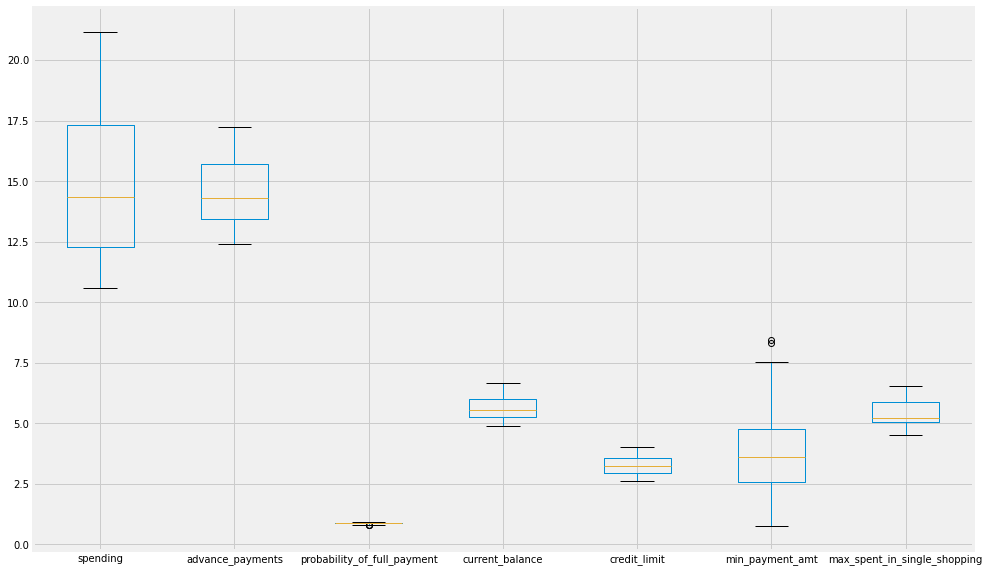

In [9]:
bank.boxplot(figsize=(15,10));

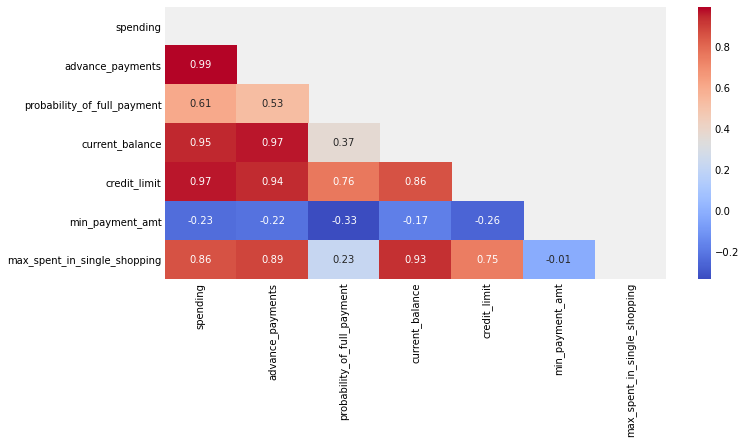

In [10]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(bank.corr(method='pearson')))
sns.heatmap(bank.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm', mask=mask);

In [11]:
#bank_df = bank.drop(['advance_payments', 'current_balance', 'credit_limit', 'current_balance'], axis = 1)
#bank_df.head()

In [12]:
bank.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

##### 1.2  Do you think scaling is necessary for clustering in this case? Justify

In [13]:
sc = StandardScaler()
bank_scaled = pd.DataFrame(sc.fit_transform(bank), columns=bank.columns)
bank_scaled.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping
0,1.754355,1.811968,0.178230,2.367533,1.338579,-0.298806,2.328998
1,0.393582,0.253840,1.501773,-0.600744,0.858236,-0.242805,-0.538582
2,1.413300,1.428192,0.504874,1.401485,1.317348,-0.221471,1.509107
3,-1.384034,-1.227533,-2.591878,-0.793049,-1.639017,0.987884,-0.454961
4,1.082581,0.998364,1.196340,0.591544,1.155464,-1.088154,0.874813


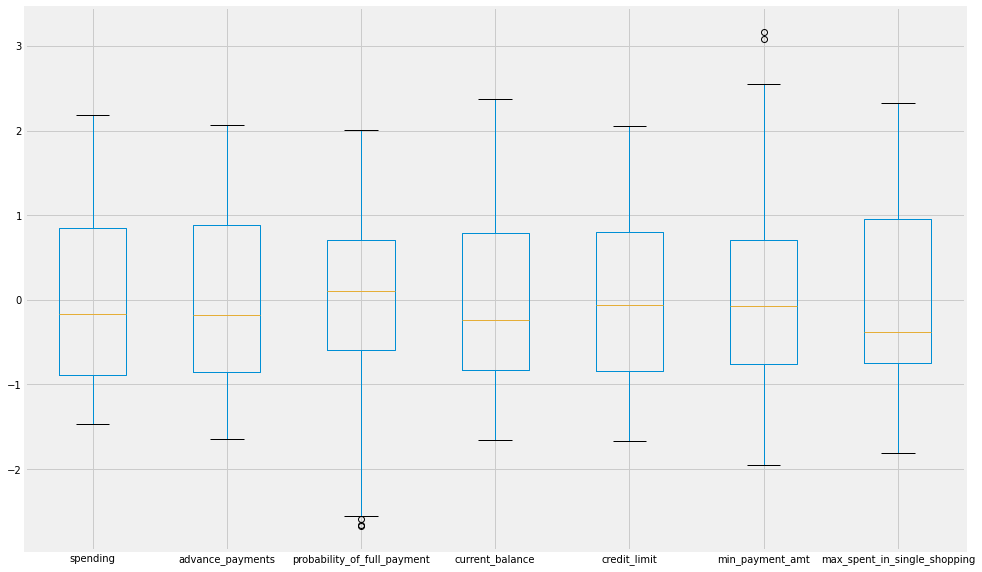

In [14]:
bank_scaled.boxplot(figsize=(15,10));

##### 1.3 Apply hierarchical clustering to scaled data. Identify the number of optimum clusters using Dendrogram and briefly describe them

In [15]:
wardlink = linkage(bank_scaled, method='ward')

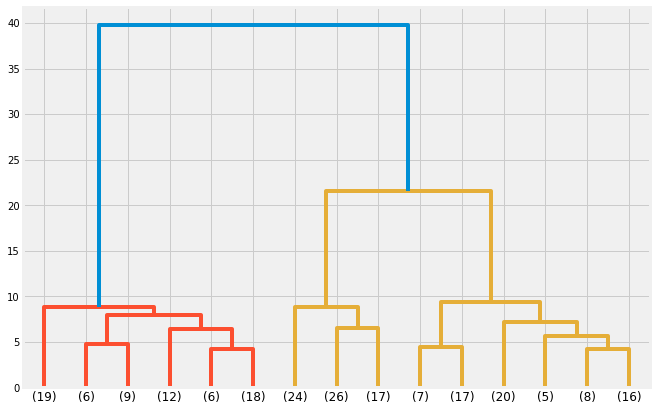

In [16]:
plt.figure(figsize=(10, 7))
dendrogram(wardlink, truncate_mode='lastp', p=15);

In [17]:
cl = fcluster(wardlink, 15, criterion='distance')
cl

array([1, 3, 1, 2, 1, 2, 2, 3, 1, 2, 1, 3, 2, 1, 3, 2, 3, 2, 3, 2, 2, 2,
       1, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 2, 2, 3, 3, 1,
       1, 3, 1, 2, 3, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1,
       1, 2, 3, 1, 3, 2, 2, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 1,
       3, 3, 1, 2, 2, 1, 3, 3, 2, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 3, 2, 3,
       3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 1, 2, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1,
       3, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 1, 1, 2,
       1, 2, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3], dtype=int32)

There appear to be totally 3 clusters

In [18]:
agglomerative  = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_cluster = agglomerative.fit_predict(bank_scaled)
agg_cluster

array([1, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2,
       1, 2, 0, 1, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1,
       2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1,
       1, 2, 0, 1, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2, 1,
       0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 1, 2, 0, 0, 2, 0,
       0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1,
       0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 2,
       1, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0], dtype=int64)

In [19]:
bank['agg_cluster'] = agg_cluster
bank.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,agg_cluster
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,0
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


In [20]:
bank['agg_cluster'].value_counts().sort_index()

0    73
1    70
2    67
Name: agg_cluster, dtype: int64

In [21]:
agg_df = bank.groupby(['agg_cluster']).mean()
agg_df['Freq'] = bank['agg_cluster'].value_counts().sort_index()
agg_df.index = [1,2,3]
agg_df

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
1,14.199041,14.233562,0.879190,5.478233,3.226452,2.612181,5.086178,73
2,18.371429,16.145429,0.884400,6.158171,3.684629,3.639157,6.017371,70
3,11.872388,13.257015,0.848072,5.238940,2.848537,4.949433,5.122209,67


Cluster 1

    Medium across most features, however, lowest in terms of min_payment_amt, max_spent_in_single_shopping. Higest Freq.

Cluster 2

    Highest across all features and freq is also a bit high (70)
    
Cluster 3

    Lowest in terms of spending as well as in other features. However, min_payment_amt and max_spent_in_single_shopping are  highest

##### 1.4 Apply K-Means clustering on scaled data and determine optimum clusters. Apply elbow curve and silhouette score.

#### >>>> Elbow Curve

In [22]:
bank.drop(['agg_cluster'], axis = 1, inplace=True)

In [23]:
wss = []
for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(bank_scaled)
    wss.append(kmeans.inertia_)

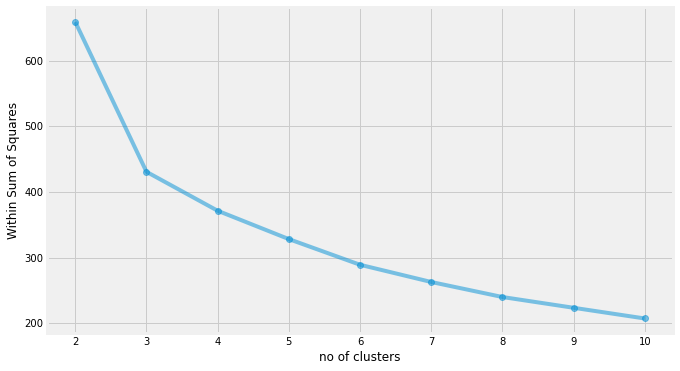

In [24]:
plt.figure(figsize=(10,6))
plt.xlabel('no of clusters')
plt.ylabel('Within Sum of Squares')
plt.plot(range(2,11), wss, alpha = 0.5, marker = 'o');

In [25]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(bank_scaled)
labels = kmeans.labels_

#### >>>> Silhouette score

In [26]:
#sil_width = silhouette_samples(bank_scaled, labels)
bank['cluster'] = labels
#bank['sil_width'] = sil_width
bank.head()

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,cluster
0,19.94,16.92,0.8752,6.675,3.763,3.252,6.550,1
1,15.99,14.89,0.9064,5.363,3.582,3.336,5.144,0
2,18.95,16.42,0.8829,6.248,3.755,3.368,6.148,1
3,10.83,12.96,0.8099,5.278,2.641,5.182,5.185,2
4,17.99,15.86,0.8992,5.890,3.694,2.068,5.837,1


In [27]:
silhouette_score(bank_scaled, labels)

0.4007270552751299

In [28]:
sil_score = []
for i in range(2,11):
    kmeans1 = KMeans(n_clusters=i)
    kmeans1.fit(bank_scaled)
    sil_score.append(silhouette_score(bank_scaled, kmeans1.labels_))

In [29]:
sil_score

[0.46577247686580914,
 0.4007270552751299,
 0.3291966792017613,
 0.27363826191254537,
 0.2734540554623553,
 0.2842363875571773,
 0.27906365917046927,
 0.25351401206930996,
 0.2522493485984284]

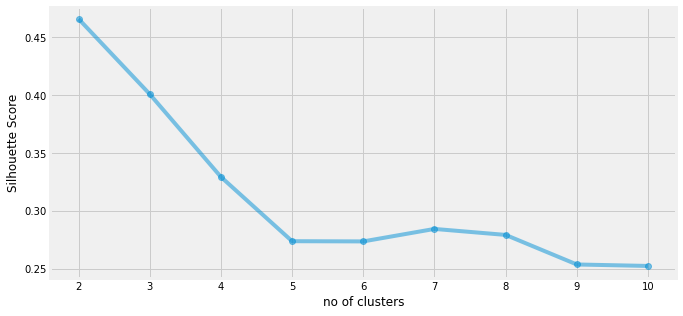

In [30]:
plt.figure(figsize = (10,5))
plt.xlabel('no of clusters')
plt.ylabel('Silhouette Score')
plt.plot(range(2,11), sil_score, alpha = 0.5, marker = 'o');

The clusters are somewhat well segregated, or in other terms, the distance between the clusters is relatively significant.

##### 1.5 Describe cluster profiles for the clusters defined. Recommend different promotional strategies for different clusters.

In [31]:
#bank['cluster'].value_counts(normalize=True).sort_index()
bank['cluster'].value_counts(normalize=True).sort_index()

0    0.338095
1    0.319048
2    0.342857
Name: cluster, dtype: float64

In [32]:
km_bank_df = bank.groupby('cluster').mean()
km_bank_df['Freq'] = bank['cluster'].value_counts().sort_index()
km_bank_df.index = [1,2,3]
km_bank_df

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
1,14.437887,14.337746,0.881597,5.514577,3.259225,2.707341,5.120803,71
2,18.495373,16.203433,0.884210,6.175687,3.697537,3.632373,6.041701,67
3,11.856944,13.247778,0.848253,5.231750,2.849542,4.742389,5.101722,72


##### Cluster 1

Lowest in terms of spending as well as in other features. However, min_payment_amt, max_spent_in_single_shopping are  highest. Freq is also highest (72)

##### Cluster 2

Highest across almost all features. min_payment_amt	 medium range. Freq is lowest (67)

##### Cluster 3

Medium across most features, however, lowest in terms of min_payment_amt. Freq almost as high as Cluster 1 (71)

Cluster 1

    Lowest in terms of spending as well as in other features. However, min_payment_amt, max_spent_in_single_shopping are  highest. Freq is also highest (72)
    

Cluster 2

    Highest across all features. Freq is lowest (67)
    
Cluster 3

    Medium across most features, however, lowest in terms of min_payment_amt. Freq almost as high as Cluster 1 (71)
    

In [33]:
bank1 = bank.copy()
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(bank_scaled)
labels1 = kmeans2.labels_
bank1['cluster'] = labels1
km_bank_df1 = bank1.groupby('cluster').mean()
km_bank_df1['Freq'] = bank1['cluster'].value_counts().sort_index()
km_bank_df1.index = [1,2]
km_bank_df1

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Freq
1,18.158571,16.054805,0.883817,6.127429,3.660519,3.480417,5.971740,77
2,12.930602,13.693459,0.863577,5.339699,3.025917,3.827444,5.081737,133


### Problem 2: CART-RF-ANN

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

#####  2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.

#### >>>> Read Data

In [34]:
insurance = pd.read_csv('insurance_part2_data.csv')
insurance.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


#### >>>> Descriptive Statistics

In [35]:
insurance.shape

(3000, 10)

In [36]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [37]:
insurance.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,3000,NaN,NaN,NaN,38.091,10.4635,8,32,36,42,84
Agency_Code,3000,4,EPX,1365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,3000,2,Travel Agency,1837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Claimed,3000,2,No,2076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Commision,3000,NaN,NaN,NaN,14.5292,25.4815,0,0,4.63,17.235,210.21
Channel,3000,2,Online,2954,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Duration,3000,NaN,NaN,NaN,70.0013,134.053,-1,11,26.5,63,4580
Sales,3000,NaN,NaN,NaN,60.2499,70.734,0,20,33,69,539
Product Name,3000,5,Customised Plan,1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,3000,3,ASIA,2465,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### >>>> Null value condition check

In [38]:
insurance.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [39]:
insurance.duplicated().sum()

139

In [40]:
print('Duplicates are around',round((139/3000)*100,2),'% of the whole dataset')

Duplicates are around 4.63 % of the whole dataset


In [41]:
for i in insurance.columns:
    if insurance[i].dtype.name == 'object':
        print(i, '\n', insurance[i].unique(), '\n', insurance[i].value_counts(), '\n\n')

Agency_Code 
 ['C2B' 'EPX' 'CWT' 'JZI'] 
 EPX    1365
C2B     924
CWT     472
JZI     239
Name: Agency_Code, dtype: int64 


Type 
 ['Airlines' 'Travel Agency'] 
 Travel Agency    1837
Airlines         1163
Name: Type, dtype: int64 


Claimed 
 ['No' 'Yes'] 
 No     2076
Yes     924
Name: Claimed, dtype: int64 


Channel 
 ['Online' 'Offline'] 
 Online     2954
Offline      46
Name: Channel, dtype: int64 


Product Name 
 ['Customised Plan' 'Cancellation Plan' 'Bronze Plan' 'Silver Plan'
 'Gold Plan'] 
 Customised Plan      1136
Cancellation Plan     678
Bronze Plan           650
Silver Plan           427
Gold Plan             109
Name: Product Name, dtype: int64 


Destination 
 ['ASIA' 'Americas' 'EUROPE'] 
 ASIA        2465
Americas     320
EUROPE       215
Name: Destination, dtype: int64 




In [42]:
insurance.head(3)

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas


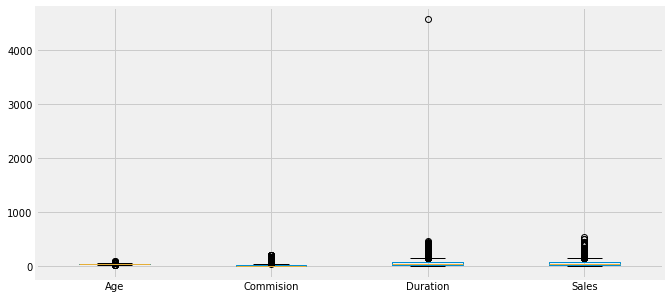

In [43]:
#numerical_list = ['Age', 'Commision', 'Duration', 'Sales']
insurance.boxplot(figsize=(10,5));

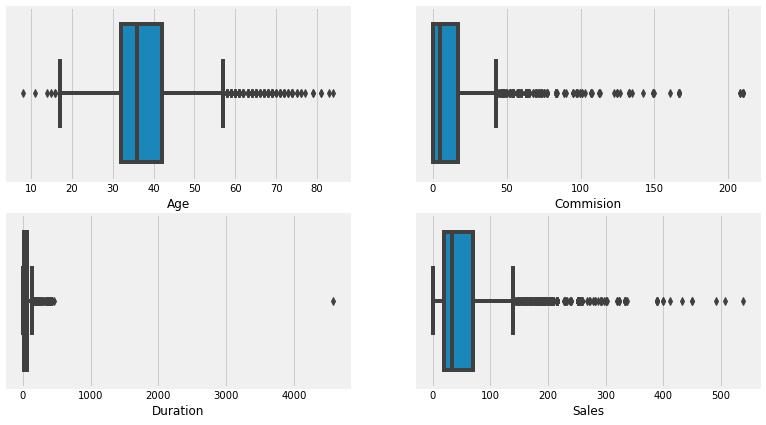

In [44]:
fig, axes = plt.subplots(2,2, figsize=(12,7))
#plt.figure(figsize=(15,10))
sns.boxplot(insurance['Age'], ax = axes[0,0]);
sns.boxplot(insurance['Commision'], ax = axes[0,1]);
sns.boxplot(insurance['Duration'], ax = axes[1,0]);
sns.boxplot(insurance['Sales'], ax = axes[1,1]);

Outliers will not have any impact on CART & Random Forest, but will affect ANN as the algorithm includes stochastic gradient descent where distance calculation is invloved

Scaling needs to be done for ANN

In [45]:
insurance['Claimed'].value_counts(normalize=True).to_frame()

,Claimed
No,0.692
Yes,0.308


#### ACTIONS BASED ON INFERENCES

#### >>>> Converting Object type variables into integer data type

In [46]:
insurance.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [47]:
insurance1 = insurance.copy()

In [48]:
for col in insurance1.columns:
    if insurance1[col].dtype.name == 'object':
        insurance1[col] = pd.Categorical(insurance1[col]).codes

In [49]:
insurance1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   int8   
 2   Type          3000 non-null   int8   
 3   Claimed       3000 non-null   int8   
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   int8   
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   int8   
 9   Destination   3000 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 111.5 KB


In [50]:
insurance1.dtypes.value_counts().to_frame()

,0
int8,6
int64,2
float64,2


In [51]:
insurance1.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0,0.00,1,34,20.00,2,0
2,39,1,1,0,5.94,1,3,9.90,2,1
3,36,2,1,0,0.00,1,4,26.00,1,0
4,33,3,0,0,6.30,1,53,18.00,0,0


#### >>>> Remove duplicates

In [52]:
insurance1.drop_duplicates(inplace=True)
insurance1.shape

(2861, 10)

#### >>>> Outlier Treatment

In [53]:
'''def treat_outliers(col):
    sorted(col)
    Q1, Q3 = np.percentile(col, [25, 75])
    IQR = Q3-Q1
    lower = Q1 - (1.5*IQR)
    upper = Q3 + (1.5*IQR)
    return lower, upper'''

'def treat_outliers(col):\n    sorted(col)\n    Q1, Q3 = np.percentile(col, [25, 75])\n    IQR = Q3-Q1\n    lower = Q1 - (1.5*IQR)\n    upper = Q3 + (1.5*IQR)\n    return lower, upper'

In [54]:
'''numerical_cols = ['Age', 'Commision', 'Duration', 'Sales']
for col in numerical_cols:
    lower, upper = treat_outliers(insurance1[col])
    insurance1[col] = np.where(insurance1[col] < lower, lower, insurance1[col])
    insurance1[col] = np.where(insurance1[col] > upper, upper, insurance1[col])'''

"numerical_cols = ['Age', 'Commision', 'Duration', 'Sales']\nfor col in numerical_cols:\n    lower, upper = treat_outliers(insurance1[col])\n    insurance1[col] = np.where(insurance1[col] < lower, lower, insurance1[col])\n    insurance1[col] = np.where(insurance1[col] > upper, upper, insurance1[col])"

In [55]:
'''fig, axes = plt.subplots(2,2, figsize=(12,7))
sns.boxplot(insurance1['Age'], ax = axes[0,0]);
sns.boxplot(insurance1['Commision'], ax = axes[0,1]);
sns.boxplot(insurance1['Duration'], ax = axes[1,0]);
sns.boxplot(insurance1['Sales'], ax = axes[1,1]);'''

"fig, axes = plt.subplots(2,2, figsize=(12,7))\nsns.boxplot(insurance1['Age'], ax = axes[0,0]);\nsns.boxplot(insurance1['Commision'], ax = axes[0,1]);\nsns.boxplot(insurance1['Duration'], ax = axes[1,0]);\nsns.boxplot(insurance1['Sales'], ax = axes[1,1]);"

In [56]:
insurance.head(3)

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas


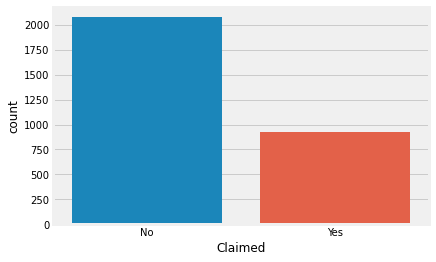

In [57]:
sns.countplot(insurance['Claimed']);

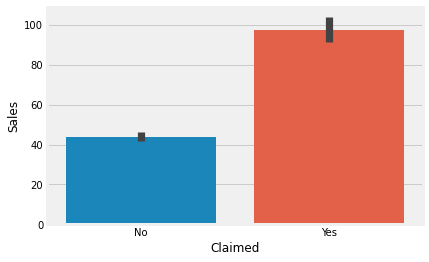

In [58]:
sns.barplot(x = 'Claimed', y = 'Sales', data = insurance);

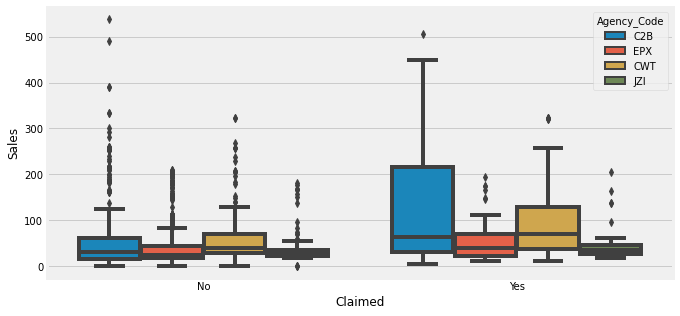

In [59]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Claimed', y = 'Sales', hue = 'Agency_Code', data = insurance);

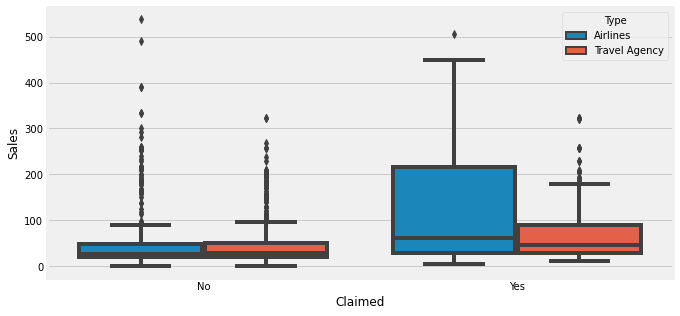

In [60]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Claimed', y = 'Sales', hue = 'Type', data = insurance);

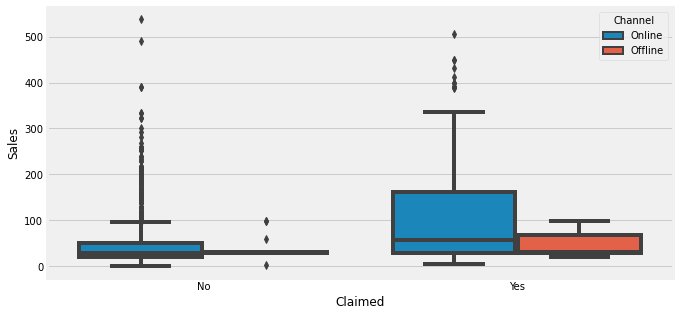

In [61]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Claimed', y = 'Sales', hue = 'Channel', data = insurance);

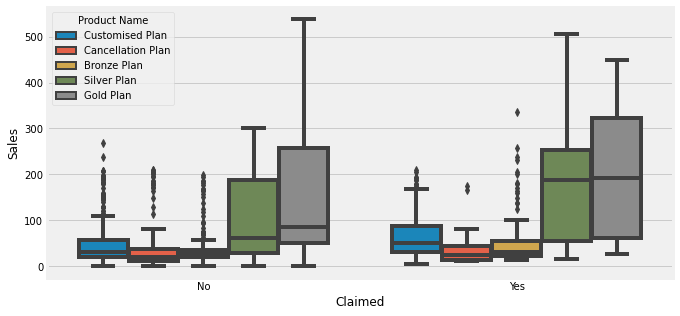

In [62]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Claimed', y = 'Sales', hue = 'Product Name', data = insurance);

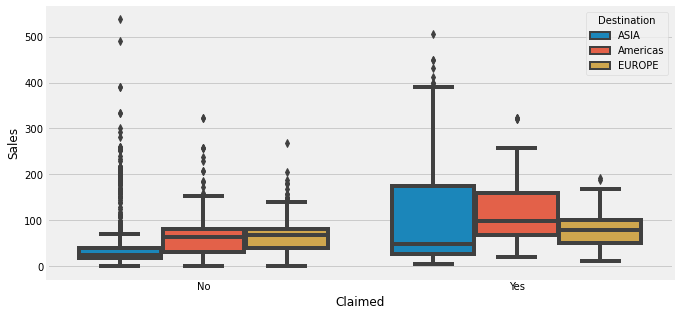

In [63]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Claimed', y = 'Sales', hue = 'Destination', data = insurance);

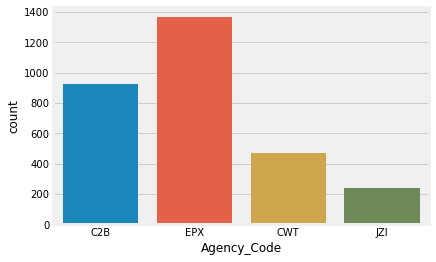

In [64]:
sns.countplot(insurance['Agency_Code']);

In [65]:
insurance1['Claimed'].value_counts(normalize=True).to_frame()

,Claimed
0,0.680531
1,0.319469


In [66]:
insurance1.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0,0.00,1,34,20.00,2,0
2,39,1,1,0,5.94,1,3,9.90,2,1
3,36,2,1,0,0.00,1,4,26.00,1,0
4,33,3,0,0,6.30,1,53,18.00,0,0


##### 2.2 Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network

#### >>>> Test & Train data split

In [67]:
X = insurance1.drop(['Claimed'], axis = 1)
y = insurance1['Claimed']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 50)

#### >>>> CART (Decision Tree)

In [69]:
params = { 'max_depth': np.arange(7,50,10),
           'min_samples_split': np.arange(10,80,10),
           'min_samples_leaf': np.arange(10,80,10)
        }

In [70]:
cart_model = DecisionTreeClassifier()
grid_cv = GridSearchCV(estimator = cart_model, param_grid=params, cv = 5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 7, 17, 27, 37, 47]),
                         'min_samples_leaf': array([10, 20, 30, 40, 50, 60, 70]),
                         'min_samples_split': array([10, 20, 30, 40, 50, 60, 70])})

In [71]:
grid_cv.best_params_

{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 40}

In [72]:
grid_cv.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=40)

In [73]:
#grid_cv.best_estimator_

In [74]:
best_grid_cart = grid_cv.best_estimator_
y_train_predict_cart = best_grid_cart.predict(X_train)
y_test_predict_cart = best_grid_cart.predict(X_test)

In [75]:
grid_cv.best_score_

0.7657294264339153

#### >>>> Random Forest

In [76]:
params = { 'n_estimators': [100,300,500],
           'max_depth': np.arange(7,50,10),
           'min_samples_split': np.arange(10,60,10),
           'min_samples_leaf': np.arange(10,60,10)
         }

In [77]:
rf_model = RandomForestClassifier()
grid_cv = GridSearchCV(estimator=rf_model, param_grid=params, cv=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 7, 17, 27, 37, 47]),
                         'min_samples_leaf': array([10, 20, 30, 40, 50]),
                         'min_samples_split': array([10, 20, 30, 40, 50]),
                         'n_estimators': [100, 300, 500]})

In [78]:
grid_cv.best_estimator_

RandomForestClassifier(max_depth=7, min_samples_leaf=20, min_samples_split=10)

In [79]:
best_grid_rf = grid_cv.best_estimator_
y_train_predict_rf = best_grid_rf.predict(X_train)
y_test_predict_rf = best_grid_rf.predict(X_test)

In [80]:
grid_cv.best_score_

0.7722306733167082

#### >>>> Artificial Neural Network

In [81]:
sc = StandardScaler()
X_train_ann = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_ann = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [82]:
params = { 'hidden_layer_sizes': [(100,100,100), (100,300,500)],
           'activation': ['relu', 'logistic'],
           'solver': ['sgd', 'adam'],
           'tol': [0.00000001, 0.001],
           'max_iter': [10000, 20000]
        }

In [83]:
ann_model = MLPClassifier()
grid_cv = GridSearchCV(estimator=ann_model, param_grid=params, cv=5)
grid_cv.fit(X_train_ann, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'logistic'],
                         'hidden_layer_sizes': [(100, 100, 100),
                                                (100, 300, 500)],
                         'max_iter': [10000, 20000], 'solver': ['sgd', 'adam'],
                         'tol': [1e-08, 0.001]})

In [84]:
grid_cv.best_estimator_

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=20000, solver='sgd',
              tol=1e-08)

In [85]:
grid_cv.best_score_

0.7652344139650873

In [86]:
best_grid_ann = grid_cv.best_estimator_
y_train_predict_ann = best_grid_ann.predict(X_train_ann)
y_test_predict_ann = best_grid_ann.predict(X_test_ann)

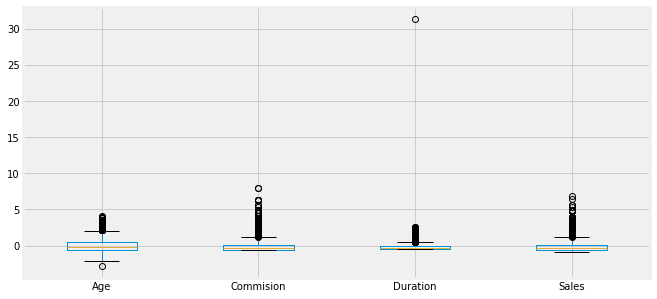

In [107]:
X_train_ann[['Age', 'Commision', 'Duration', 'Sales']].boxplot(figsize=(10,5));

In [108]:
X_train_ann

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,-0.213748,0.693744,0.800615,-0.597873,0.12946,0.047947,-0.383773,-0.514445,-0.445561
1,-0.770216,-1.311851,-1.249041,-0.042509,0.12946,-0.285668,-0.082280,1.880715,-0.445561
2,-0.770216,0.693744,0.800615,-0.597873,0.12946,-0.237016,0.508474,0.283942,1.256755
3,0.157230,-0.309054,0.800615,0.380292,0.12946,-0.348221,-0.288792,0.283942,1.256755
4,0.064486,-0.309054,0.800615,0.380292,0.12946,0.430215,-0.288792,0.283942,-0.445561
...,...,...,...,...,...,...,...,...,...
1997,-0.213748,0.693744,0.800615,-0.597873,0.12946,-0.313469,-0.570857,0.283942,-0.445561
1998,-0.028259,-1.311851,-1.249041,2.004391,0.12946,2.202546,2.780105,1.880715,-0.445561
1999,2.197613,0.693744,0.800615,-0.597873,0.12946,-0.396873,-0.542074,-0.514445,-0.445561
2000,-2.810599,-0.309054,0.800615,-0.203890,-7.72442,-0.132761,-0.441337,0.283942,-0.445561


##### 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model

#### Performance of Predictions on TRAIN

#### >>> Accuracy &  Confusion Matrix

In [88]:
model_names = ['CART', 'Random Forest', 'ANN']

CART Model 

 Accuracy:	 0.7977022977022977 

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1380
           1       0.71      0.59      0.65       622

    accuracy                           0.80      2002
   macro avg       0.77      0.74      0.75      2002
weighted avg       0.79      0.80      0.79      2002
 



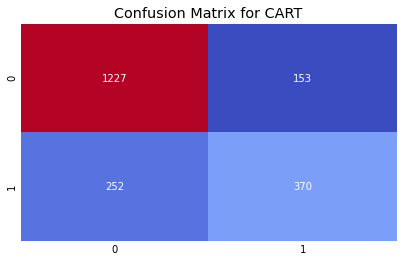


--------------------------------------------------------
Random Forest Model 

 Accuracy:	 0.7922077922077922 

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1380
           1       0.72      0.55      0.62       622

    accuracy                           0.79      2002
   macro avg       0.77      0.73      0.74      2002
weighted avg       0.78      0.79      0.78      2002
 



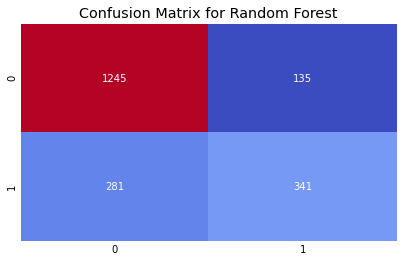


--------------------------------------------------------
ANN Model 

 Accuracy:	 0.7782217782217782 

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1380
           1       0.66      0.59      0.62       622

    accuracy                           0.78      2002
   macro avg       0.74      0.73      0.73      2002
weighted avg       0.77      0.78      0.77      2002
 



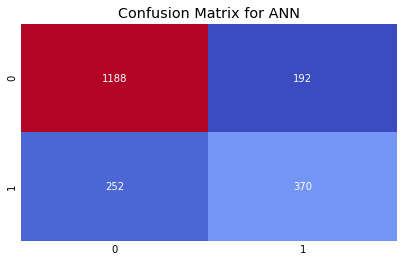


--------------------------------------------------------


In [89]:
train_predict_data = [y_train_predict_cart, y_train_predict_rf, y_train_predict_ann]
accuracy_train = []; precision_train = []; recall_train = []; f1_score_train = [] 

for model, train_pred in zip(model_names,train_predict_data):
    accuracy_train.append(accuracy_score(y_train, train_pred))
    print(model, 'Model \n\n Accuracy:\t', accuracy_score(y_train, train_pred),'\n')
    
    report_train = classification_report(y_train, train_pred, output_dict=True)
    precision_train.append(report_train['1']['precision'])
    recall_train.append(report_train['1']['recall'])
    f1_score_train.append(report_train['1']['f1-score'])
    print(classification_report(y_train, train_pred), '\n')
    
    #print(model, 'Model \n', classification_report(y_train, train_pred), '\n')
    fig, axes = plt.subplots(nrows=1, ncols=1)
    a = sns.heatmap(confusion_matrix(y_train, train_pred), fmt = 'd', annot=True, cmap = 'coolwarm', cbar=False, ax=axes)
    a.set_title('Confusion Matrix for {}'.format(model))
    plt.show()
    print('\n--------------------------------------------------------')

#### >>> ROC Curve

AUC Score for CART:		 0.8370485577147118
AUC Score for Random Forest:	 0.8395743044876276
AUC Score for ANN:		 0.675276107926744


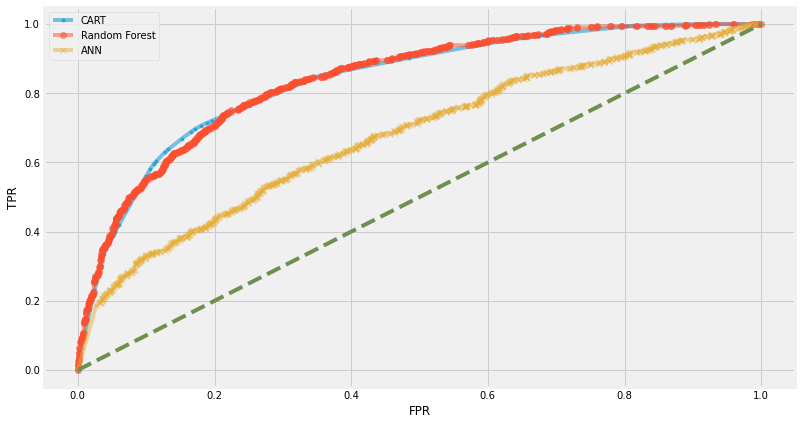

In [90]:
plt.figure(figsize=(12,7))
auc_score_train = []

auc_score_train.append(roc_auc_score(y_train, best_grid_cart.predict_proba(X_train)[:,1]))
print('AUC Score for CART:\t\t', roc_auc_score(y_train, best_grid_cart.predict_proba(X_train)[:,1]))
fpr_cart, tpr_cart, thresh_cart = roc_curve(y_train, best_grid_cart.predict_proba(X_train)[:,1])
plt.plot(fpr_cart, tpr_cart, marker = '.', alpha = 0.5)

auc_score_train.append(roc_auc_score(y_train, best_grid_rf.predict_proba(X_train)[:,1]))
print('AUC Score for Random Forest:\t', roc_auc_score(y_train, best_grid_rf.predict_proba(X_train)[:,1]))
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_train, best_grid_rf.predict_proba(X_train)[:,1])
plt.plot(fpr_rf, tpr_rf, marker = 'o', alpha = 0.5)

auc_score_train.append(roc_auc_score(y_train, best_grid_ann.predict_proba(X_train)[:,1]))
print('AUC Score for ANN:\t\t', roc_auc_score(y_train, best_grid_ann.predict_proba(X_train)[:,1]))
fpr_ann, tpr_ann, thresh_ann = roc_curve(y_train, best_grid_ann.predict_proba(X_train)[:,1])
plt.plot(fpr_ann, tpr_ann, marker = 'x', alpha = 0.5)


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0,1], [0,1], linestyle='--')
plt.legend(model_names)
plt.show()

In [91]:
class_rep_cart = classification_report(y_train, y_train_predict_cart, output_dict=True)
cart_train_precision, cart_train_recall_, cart_train_f1score = round(class_rep_cart['1']['precision'],2),round(class_rep_cart['1']['recall'],2),round(class_rep_cart['1']['f1-score'],2)
cart_train_precision, cart_train_recall_, cart_train_f1score

(0.71, 0.59, 0.65)

In [92]:
print(classification_report(y_train, y_train_predict_cart))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1380
           1       0.71      0.59      0.65       622

    accuracy                           0.80      2002
   macro avg       0.77      0.74      0.75      2002
weighted avg       0.79      0.80      0.79      2002



In [93]:
classification_report(y_train, y_train_predict_cart,output_dict=True)

{'0': {'precision': 0.8296146044624746,
  'recall': 0.8891304347826087,
  'f1-score': 0.8583420776495277,
  'support': 1380},
 '1': {'precision': 0.7074569789674953,
  'recall': 0.594855305466238,
  'f1-score': 0.646288209606987,
  'support': 622},
 'accuracy': 0.7977022977022977,
 'macro avg': {'precision': 0.7685357917149849,
  'recall': 0.7419928701244234,
  'f1-score': 0.7523151436282574,
  'support': 2002},
 'weighted avg': {'precision': 0.7916615360019965,
  'recall': 0.7977022977022977,
  'f1-score': 0.7924592075583887,
  'support': 2002}}

#### Performance of Predictions on TEST

#### >>> Accuracy & Confusion Matrix

CART Model 

 Accuracy:	 0.7532013969732246 

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       567
           1       0.64      0.63      0.63       292

    accuracy                           0.75       859
   macro avg       0.72      0.72      0.72       859
weighted avg       0.75      0.75      0.75       859
 



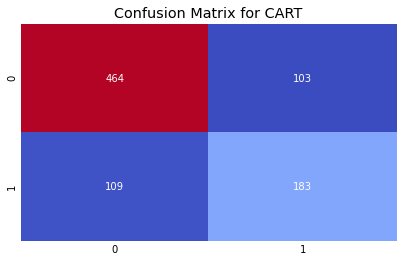


--------------------------------------------------------
Random Forest Model 

 Accuracy:	 0.7753201396973225 

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       567
           1       0.69      0.62      0.65       292

    accuracy                           0.78       859
   macro avg       0.75      0.74      0.74       859
weighted avg       0.77      0.78      0.77       859
 



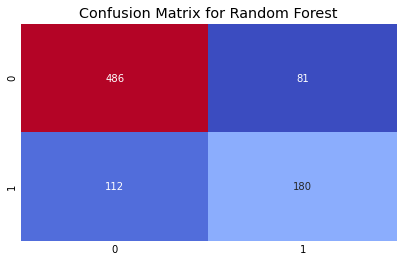


--------------------------------------------------------
ANN Model 

 Accuracy:	 0.7741559953434226 

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       567
           1       0.67      0.66      0.67       292

    accuracy                           0.77       859
   macro avg       0.75      0.75      0.75       859
weighted avg       0.77      0.77      0.77       859
 



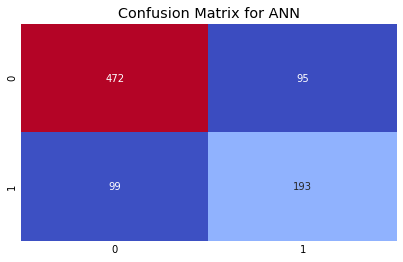


--------------------------------------------------------


In [94]:
test_predict_data = [y_test_predict_cart, y_test_predict_rf, y_test_predict_ann]
accuracy_test = []; precision_test = []; recall_test = []; f1_score_test = []

for model, test_pred in zip(model_names,test_predict_data):
    accuracy_test.append(accuracy_score(y_test, test_pred))
    print(model, 'Model \n\n Accuracy:\t', accuracy_score(y_test, test_pred),'\n')
    
    report_test = classification_report(y_test, test_pred, output_dict=True)
    precision_test.append(report_test['1']['precision'])
    recall_test.append(report_test['1']['recall'])
    f1_score_test.append(report_test['1']['f1-score'])
    print(classification_report(y_test, test_pred), '\n')
    
    fig, axes = plt.subplots(nrows=1, ncols=1)
    a = sns.heatmap(confusion_matrix(y_test, test_pred), fmt = 'd', annot=True, cmap = 'coolwarm', cbar=False, ax=axes)
    a.set_title('Confusion Matrix for {}'.format(model))
    plt.show()
    print('\n--------------------------------------------------------')

#### >>> ROC Curve

AUC Score for CART:		 0.8069900461452972
AUC Score for Random Forest:	 0.8206916962624724
AUC Score for ANN:		 0.6857861612427822


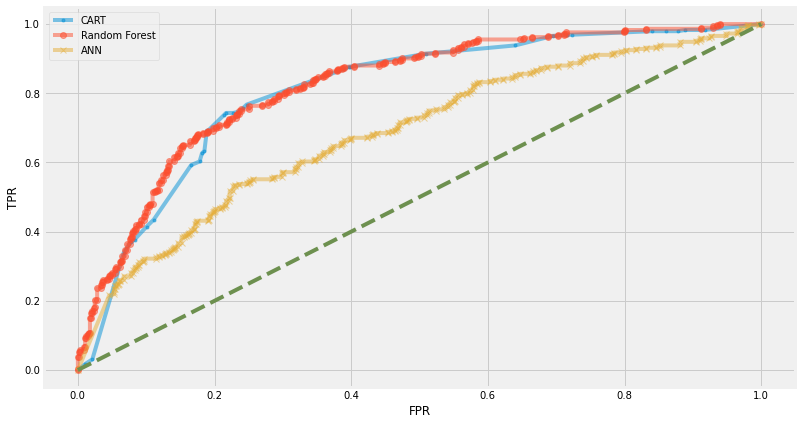

In [95]:
plt.figure(figsize=(12,7))
auc_score_test = []

auc_score_test.append(roc_auc_score(y_test, best_grid_cart.predict_proba(X_test)[:,1]))
print('AUC Score for CART:\t\t', roc_auc_score(y_test, best_grid_cart.predict_proba(X_test)[:,1]))
fpr_cart_test, tpr_cart_test, thresh_cart_test = roc_curve(y_test, best_grid_cart.predict_proba(X_test)[:,1])
plt.plot(fpr_cart_test, tpr_cart_test, marker = '.', alpha = 0.5)

auc_score_test.append(roc_auc_score(y_test, best_grid_rf.predict_proba(X_test)[:,1]))
print('AUC Score for Random Forest:\t', roc_auc_score(y_test, best_grid_rf.predict_proba(X_test)[:,1]))
fpr_rf_test, tpr_rf_test, thresh_rf_test = roc_curve(y_test, best_grid_rf.predict_proba(X_test)[:,1])
plt.plot(fpr_rf_test, tpr_rf_test, marker = 'o', alpha = 0.5)

auc_score_test.append(roc_auc_score(y_test, best_grid_ann.predict_proba(X_test)[:,1]))
print('AUC Score for ANN:\t\t', roc_auc_score(y_test, best_grid_ann.predict_proba(X_test)[:,1]))
fpr_ann_test, tpr_ann_test, thresh_ann_test = roc_curve(y_test, best_grid_ann.predict_proba(X_test)[:,1])
plt.plot(fpr_ann_test, tpr_ann_test, marker = 'x', alpha = 0.5)


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot([0,1], [0,1], linestyle='--')
plt.legend(model_names)
plt.show()

##### 2.4 Final Model: Compare all the model and write an inference which model is best/optimized.

In [96]:
model_performance = pd.DataFrame({'Acc Train':np.round([i*100 for i in accuracy_train],2), 
                                   'Acc Test':np.round([i*100 for i in accuracy_test],2), 
                                   'AUC Score Train': np.round([i*100 for i in auc_score_train],2),
                                   'AUC Score Test': np.round([i*100 for i in auc_score_test],2)
                                  },
                                index = ['CART', 'Random Forest', 'ANN'])
model_performance

,Acc Train,Acc Test,AUC Score Train,AUC Score Test
CART,79.77,75.32,83.70,80.70
Random Forest,79.22,77.53,83.96,82.07
ANN,77.82,77.42,67.53,68.58


In [97]:
model_performance1 = pd.DataFrame({'Acc Train':np.round([i*100 for i in accuracy_train],2), 
                                   'Acc Test':np.round([i*100 for i in accuracy_test],2), 
                                   'AUC Score Train': np.round([i*100 for i in auc_score_train],2),
                                   'AUC Score Test': np.round([i*100 for i in auc_score_test],2),
                                   'Precison_Train': np.round([i*100 for i in precision_train],2),
                                   'Precison_Test': np.round([i*100 for i in precision_test],2),
                                   'Recall_Train': np.round([i*100 for i in recall_train],2),
                                   'Recall_Test': np.round([i*100 for i in recall_test],2),
                                   'F1_Score_Train': np.round([i*100 for i in f1_score_train],2),
                                   'F1_Score_Test': np.round([i*100 for i in f1_score_test],2)
                                  },
                                index = ['CART', 'Random Forest', 'ANN'])
model_performance1

,Acc Train,Acc Test,AUC Score Train,AUC Score Test,Precison_Train,Precison_Test,Recall_Train,Recall_Test,F1_Score_Train,F1_Score_Test
CART,79.77,75.32,83.70,80.70,70.75,63.99,59.49,62.67,64.63,63.32
Random Forest,79.22,77.53,83.96,82.07,71.64,68.97,54.82,61.64,62.11,65.10
ANN,77.82,77.42,67.53,68.58,65.84,67.01,59.49,66.10,62.50,66.55


In [104]:
model_performance1.T

,CART,Random Forest,ANN
Acc Train,79.77,79.22,77.82
Acc Test,75.32,77.53,77.42
AUC Score Train,83.70,83.96,67.53
AUC Score Test,80.70,82.07,68.58
Precison_Train,70.75,71.64,65.84
Precison_Test,63.99,68.97,67.01
Recall_Train,59.49,54.82,59.49
Recall_Test,62.67,61.64,66.10
F1_Score_Train,64.63,62.11,62.50
F1_Score_Test,63.32,65.10,66.55


In [98]:
accuracy_train

[0.7977022977022977, 0.7922077922077922, 0.7782217782217782]

In [99]:
accuracy_test

[0.7532013969732246, 0.7753201396973225, 0.7741559953434226]

In [100]:
auc_score_train

[0.8370485577147118, 0.8395743044876276, 0.675276107926744]

In [101]:
auc_score_test

[0.8069900461452972, 0.8206916962624724, 0.6857861612427822]

In [102]:
pd.Series(y_test_predict_rf).value_counts(normalize=True).to_frame()

,0
0,0.696158
1,0.303842


In [103]:
insurance['Claimed'].value_counts(normalize=True).to_frame()

,Claimed
No,0.692
Yes,0.308


##### 2.5 Inference: Based on the whole Analysis, what are the business insights and recommendations

In [117]:
pd.DataFrame(best_grid_rf.feature_importances_, index=X_train.columns, columns=['Imp']).sort_values('Imp',ascending=False)

,Imp
Agency_Code,0.290647
Product Name,0.219216
Sales,0.175596
Commision,0.096774
Duration,0.090936
Type,0.061672
Age,0.050213
Destination,0.014558
Channel,0.000387


In [119]:
feature_imp = np.round([i*100 for i in best_grid_rf.feature_importances_],2)
pd.DataFrame(feature_imp, index=X_train.columns, columns=['Imp%']).sort_values('Imp%',ascending=False)

,Imp%
Agency_Code,29.06
Product Name,21.92
Sales,17.56
Commision,9.68
Duration,9.09
Type,6.17
Age,5.02
Destination,1.46
Channel,0.04
